In [1]:
# Import von Bibliotheken

import argparse
import os
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
from torchvision.models import vgg19
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.autograd import Variable
import glob
from PIL import Image
import cv2
from numpy.random import randint, uniform
import matplotlib.pyplot as plt
from modules import ConvBlock

%matplotlib inline

In [2]:
!gpustat

mst-hpc-kai          Fri Jan 19 11:06:59 2024  525.147.05
[0] NVIDIA RTX A6000 | 37°C,   8 % | 41371 / 49140 MB | qzhang(664M) qzhang(664M) rowe672d(6038M) cxwang(31140M) mlin(2860M)
[1] NVIDIA RTX A6000 | 31°C,   0 % |  2163 / 49140 MB | tglosemeyer(2158M)
[2] NVIDIA RTX A6000 | 74°C, 100 % | 27985 / 49140 MB | qzhang(1344M) tglosemeyer(25058M) nkirsch(1576M)
[3] NVIDIA RTX A6000 | 30°C,   0 % |  1619 / 49140 MB | qzhang(1612M)
[4] NVIDIA RTX A6000 | 29°C,   0 % |     7 / 49140 MB |
[5] NVIDIA RTX A6000 | 31°C,   0 % |     5 / 49140 MB |


Epoch [0/100] Batch [0/625] Discriminator Loss: 9.1317, Generator Loss: 1.5066
Epoch [0/100] Batch [100/625] Discriminator Loss: 2.9472, Generator Loss: 1.0008
Epoch [0/100] Batch [200/625] Discriminator Loss: 4.8974, Generator Loss: 1.0003
Epoch [0/100] Batch [300/625] Discriminator Loss: 7.9865, Generator Loss: 0.9979
Epoch [0/100] Batch [400/625] Discriminator Loss: 8.0828, Generator Loss: 0.9980
Epoch [0/100] Batch [500/625] Discriminator Loss: 9.0029, Generator Loss: 0.9970
Epoch [0/100] Batch [600/625] Discriminator Loss: 4.9787, Generator Loss: 1.0004
Epoch [1/100] Batch [0/625] Discriminator Loss: 8.7531, Generator Loss: 0.9985
Epoch [1/100] Batch [100/625] Discriminator Loss: 8.3293, Generator Loss: 1.0021
Epoch [1/100] Batch [200/625] Discriminator Loss: 11.7114, Generator Loss: 1.0002
Epoch [1/100] Batch [300/625] Discriminator Loss: 8.8000, Generator Loss: 1.0025
Epoch [1/100] Batch [400/625] Discriminator Loss: 8.3759, Generator Loss: 1.0010
Epoch [1/100] Batch [500/625] D

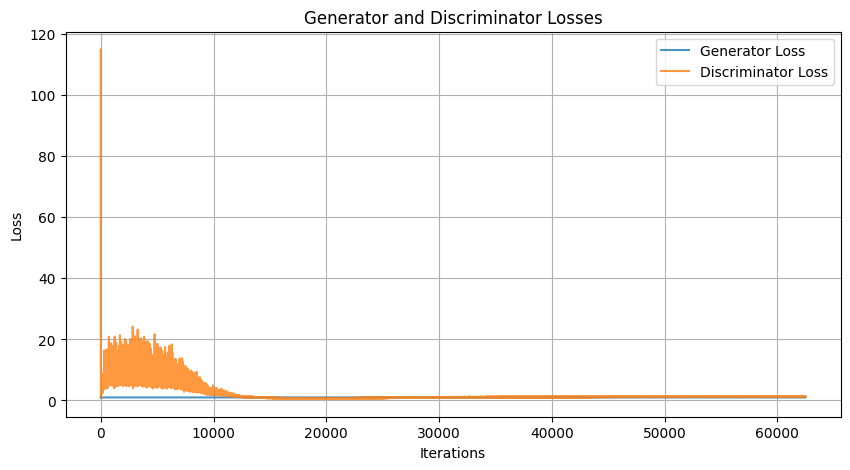

In [3]:
#Improvements made in this code include:
#Removed duplicate LeakyReLU after each convolutional layer.
#Removed redundant max-pooling layer after the last set of convolutional layers.
#Adjusted the spectral normalization function to be applied to both convolutional and linear layers.
#Improved code readability and consistency.

device_index =4
device=torch.device(f"cuda:{device_index}" if torch.cuda.is_available() else "cpu")
class Generator_1(nn.Module):
    def __init__(self):
        super(Generator_1, self).__init__()
        
        self.enc_conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.enc_conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        
        ########################
        self.dec_conv1 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.dec_conv2 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.dec_conv3 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.dec_conv4 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)
        
        self.batch_norm_dec1 = nn.BatchNorm2d(256)
        self.batch_norm_dec2 = nn.BatchNorm2d(128)
        self.batch_norm_dec3 = nn.BatchNorm2d(64)
        
    def forward(self, x):
        x1 = F.relu(self.enc_conv1(x))
        x2 = F.relu(self.enc_conv2(x1))
        x3 = F.relu(self.enc_conv3(x2))
        x4 = F.relu(self.enc_conv4(x3))
        
        x = F.relu(self.batch_norm_dec1(self.dec_conv1(x4)))
        x = F.relu(self.batch_norm_dec2(self.dec_conv2(x)))
        x = F.relu(self.batch_norm_dec3(self.dec_conv3(x)))
        x = torch.tanh(self.dec_conv4(x))
        
        return x




class ImprovedVGGDiscriminator(nn.Module):
    def __init__(self):
        super(ImprovedVGGDiscriminator, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
           
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 16 * 16, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1)
        )

        self.apply_spectral_norm()

    def apply_spectral_norm(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.utils.spectral_norm(m)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


class CustomDataset(Dataset):
    def __init__(self, file_paths_meas, file_paths_truth):
        self.file_paths_meas = file_paths_meas
        self.file_paths_truth = file_paths_truth

    def __len__(self):
        return len(self.file_paths_meas)

    def __getitem__(self, idx):
        img_x = cv2.imread(self.file_paths_meas[idx], cv2.IMREAD_GRAYSCALE)
        img_x = cv2.resize(img_x, (128, 128))
        img_x = img_x.reshape((1, 128, 128)).astype(np.float32)
        img_x = torch.from_numpy(img_x)

        img_y = cv2.imread(self.file_paths_truth[idx], cv2.IMREAD_GRAYSCALE)
        img_y = cv2.resize(img_y, (128, 128))
        img_y = img_y.reshape((1, 128, 128)).astype(np.float32)
        img_y = torch.from_numpy(img_y)

        return img_x, img_y







num_epochs = 100
batch_size = 16
train_path_meas = glob.glob('Train/Meas/*.png')
train_path_truth = glob.glob('Train/Truth/*.png')

train_dataset = CustomDataset(train_path_meas, train_path_truth)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
G_losses = []
D_losses = []
Generated_Images_0=  []
R_Images_1=  []
Generated_Images_1=  []
R_Images_3=  []
Generated_Images_3=  []
R_Images_4=  []
Generated_Images_4=  []
R_Images_5=  []
Generated_Images_5=  []
R_Images_6=  []
Generated_Images_6=  []
R_Images_7=  []
Generated_Images_7=  []
R_Images_8=  []
Generated_Images_8=  []
R_Images_9=  []
Generated_Images_9=  []
R_Images_10=  []
Generated_Images_10=  []



generator_1 = Generator_1().to(device)
discriminator = ImprovedVGGDiscriminator().to(device)
optimizer_G = torch.optim.Adam(generator_1.parameters(), lr=0.00001, betas=(0.9, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00001, betas=(0.9, 0.999))
criterion = nn.MSELoss()






for epoch in range(num_epochs): 
   
    for i, (img_x, img_y) in enumerate(train_loader):
        
        img_x = img_x.to(device)
        img_y = img_y.to(device)

       
      
        ##############################
        optimizer_D.zero_grad()

       
        real_labels = torch.ones(img_y.size(0), 1).to(device)  
        real_outputs = discriminator(img_y).view(-1, 1)
        d_loss_real = criterion(real_outputs, real_labels)

     
            
        fake_labels = torch.zeros(img_y.size(0), 1).to(device)  # Fake labels
        fake_images = generator_1(img_x)
        fake_outputs = discriminator(fake_images.detach()).view(-1, 1)
        d_loss_fake = criterion(fake_outputs, fake_labels)
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        optimizer_D.step()



        
        ##############################

        optimizer_G.zero_grad()
        fake_images = generator_1(img_x)
        outputs = discriminator(fake_images).view(-1, 1)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

       
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())
        
        
        if i % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(train_loader)}] "
                f"Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}"
            )
        if epoch ==99:
             R_Images_10= img_y
             with torch.no_grad():
                 Generated_Images_10= generator_1(img_y)
        if epoch %10==0:
            if epoch==0:
                R_Images_0= img_y
                with torch.no_grad():
                   Generated_Images_0= generator_1(img_y)
            elif epoch==10:
                R_Images_1= img_y
                with torch.no_grad():
                    Generated_Images_1= generator_1(img_y)

            elif epoch==20:
                R_Images_2= img_y
                with torch.no_grad():
                    Generated_Images_2= generator_1(img_y)

            elif epoch==30:
                R_Images_3= img_y
                with torch.no_grad():
                    Generated_Images_3= generator_1(img_y)

            elif epoch==40:
                R_Images_4= img_y
                with torch.no_grad():
                    Generated_Images_4= generator_1(img_y)

            elif epoch==50:
                R_Images_5= img_y
                with torch.no_grad():
                    Generated_Images_5= generator_1(img_y)

            elif epoch==60:
                R_Images_6= img_y
                with torch.no_grad():
                    Generated_Images_6= generator_1(img_y)
            elif epoch==70:
                R_Images_7= img_y
                with torch.no_grad():
                    Generated_Images_7= generator_1(img_y)
            elif epoch==80:
                R_Images_8= img_y
                with torch.no_grad():
                    Generated_Images_8= generator_1(img_y)
            elif epoch==90:
                R_Images_9= img_y
                with torch.no_grad():
                    Generated_Images_9= generator_1(img_y)
            
               
                
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss', alpha=0.8)
plt.plot(D_losses, label='Discriminator Loss', alpha=0.8)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses')
plt.legend()
plt.grid(True)
plt.show()



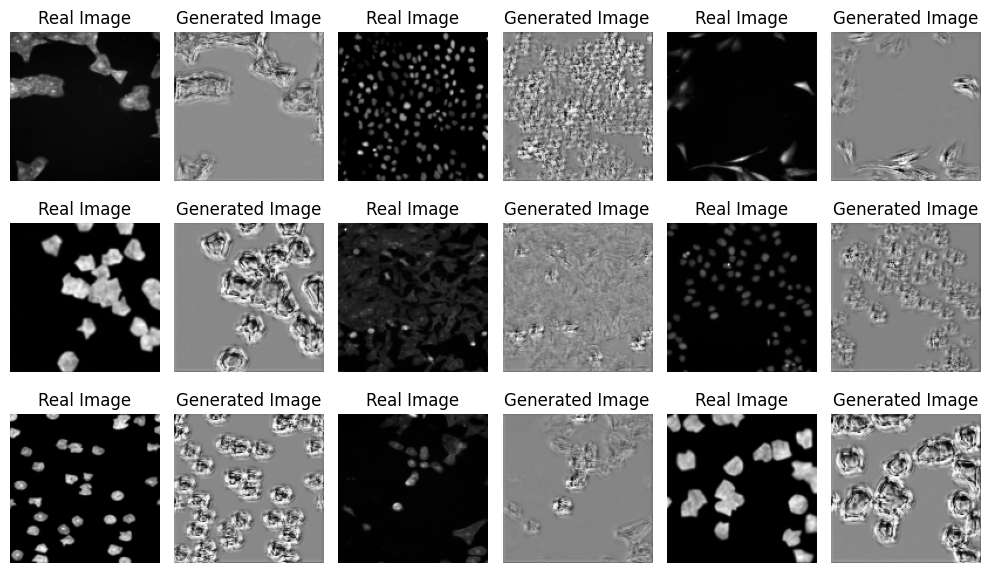

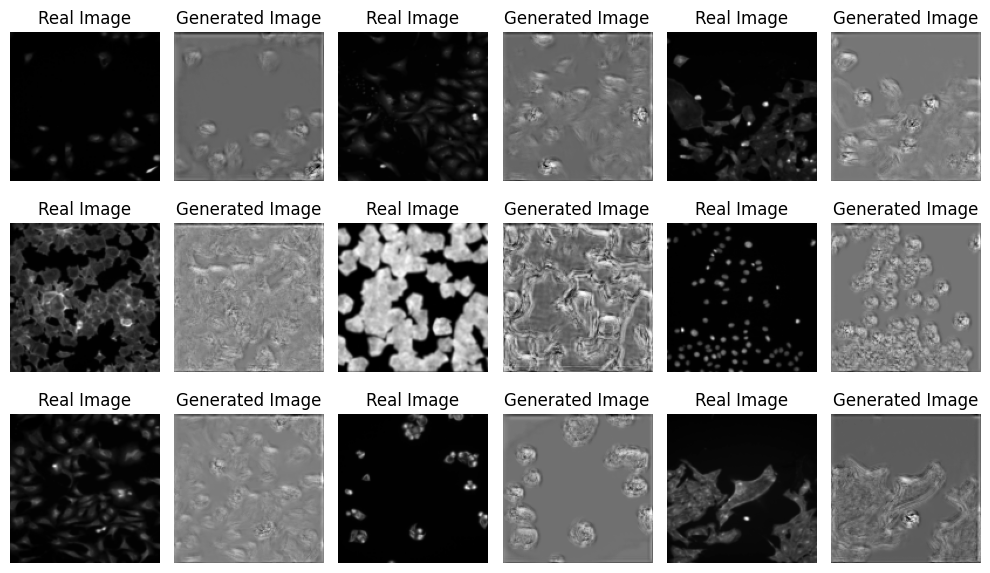

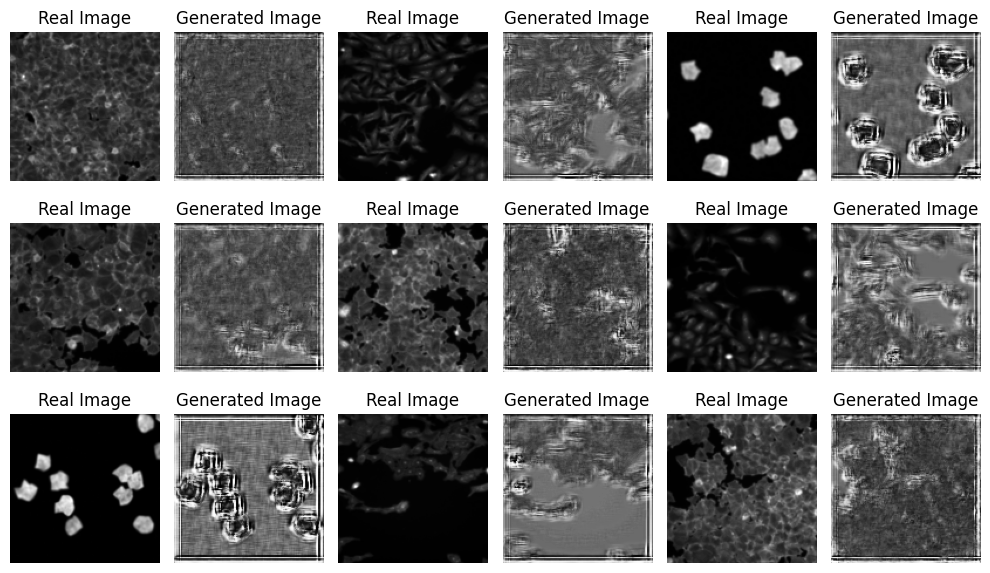

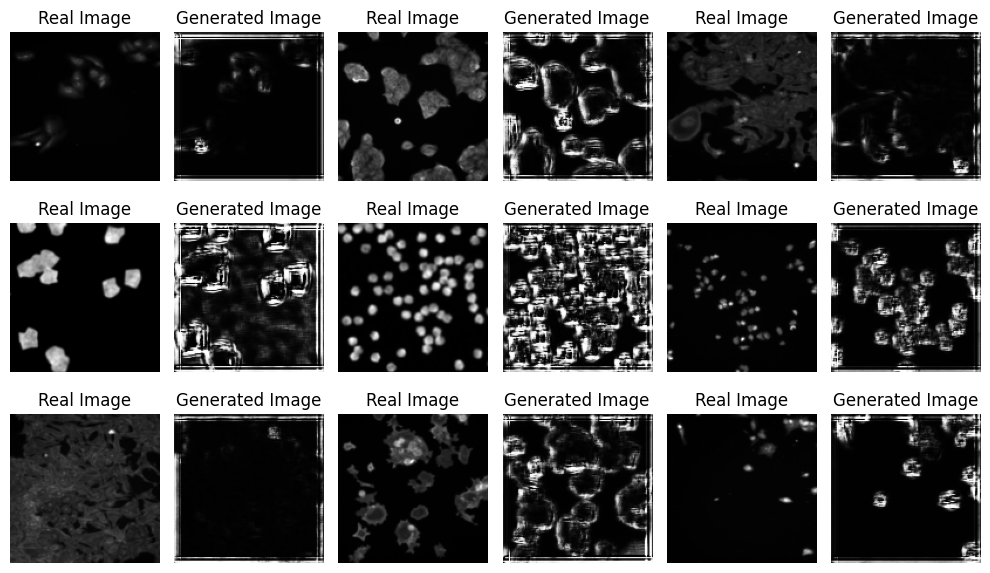

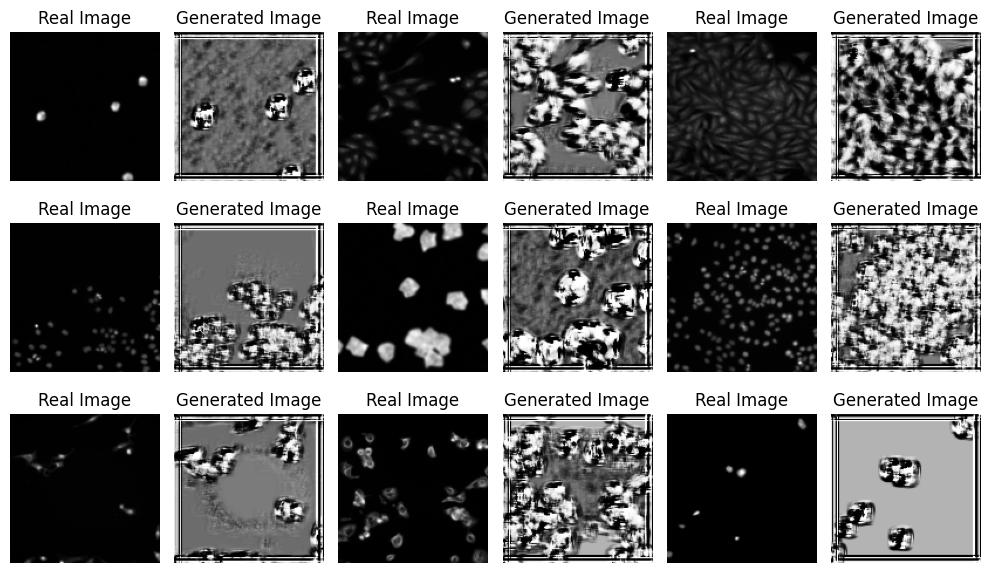

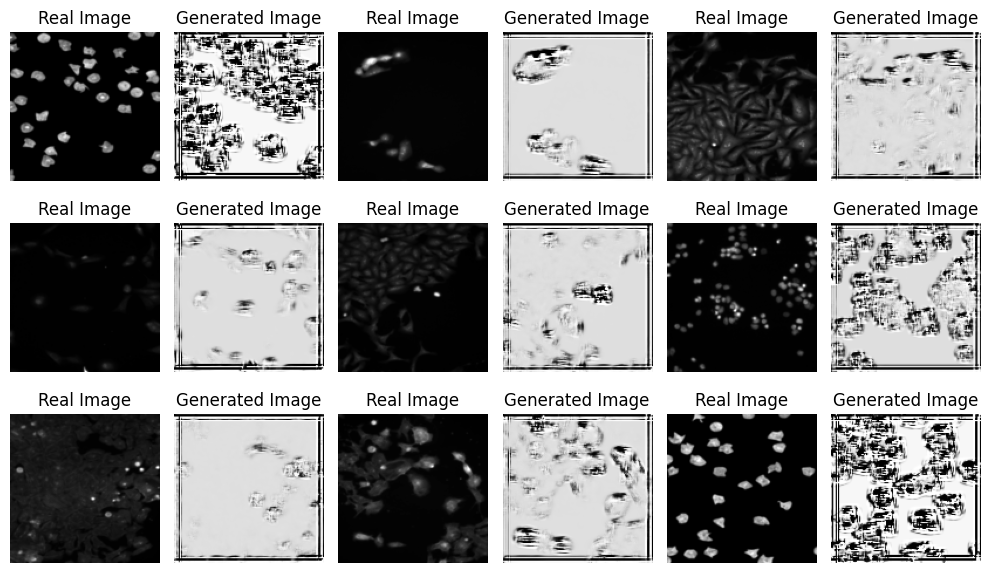

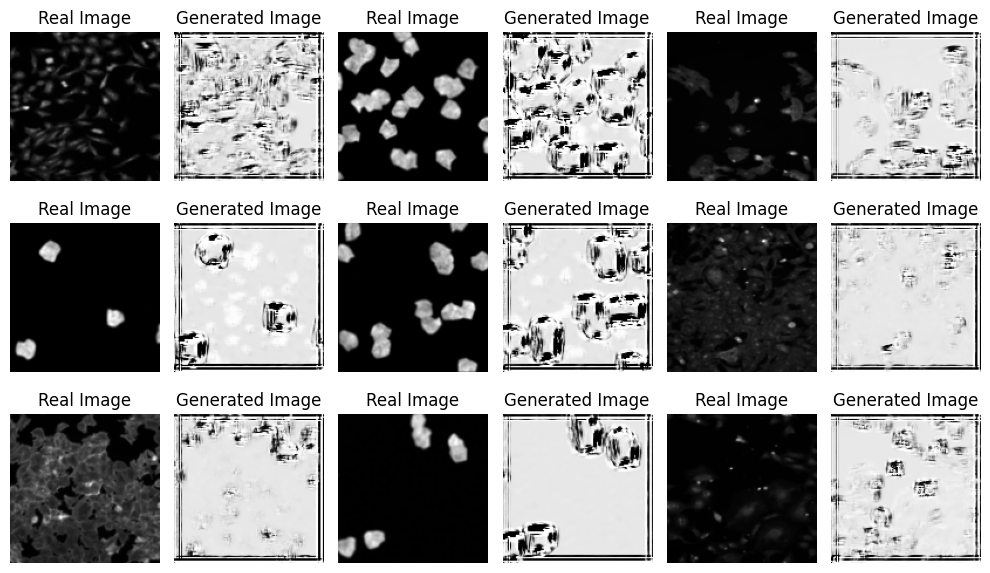

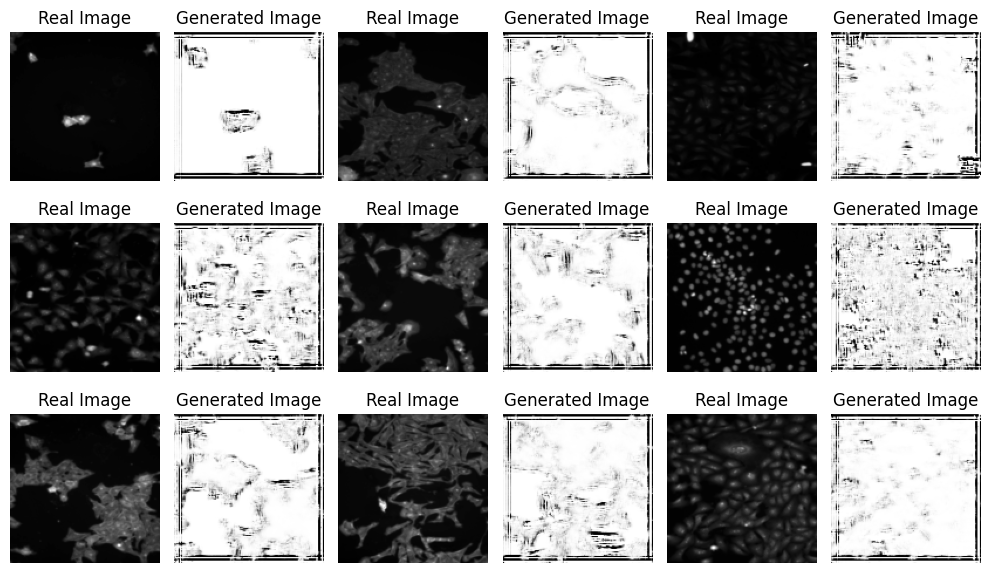

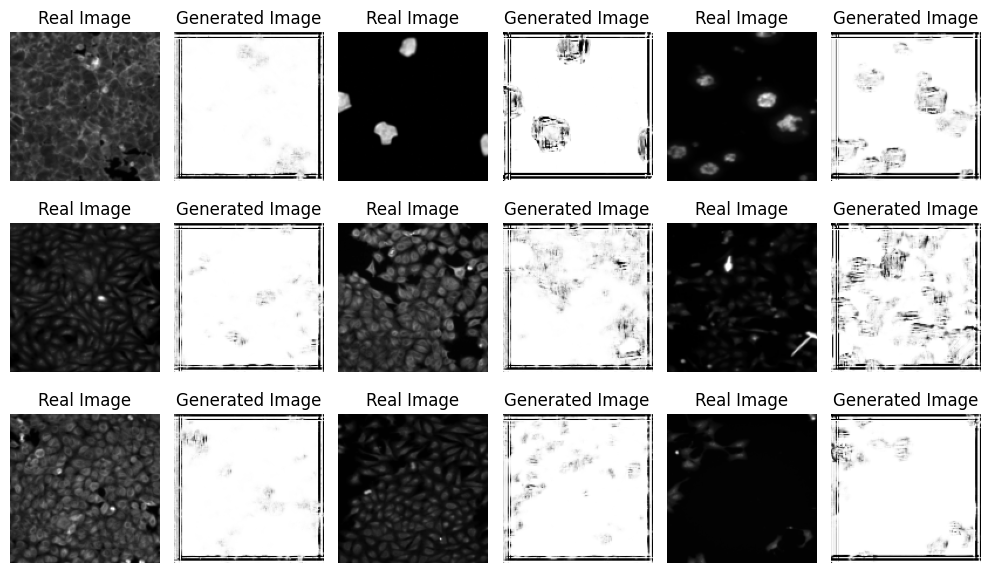

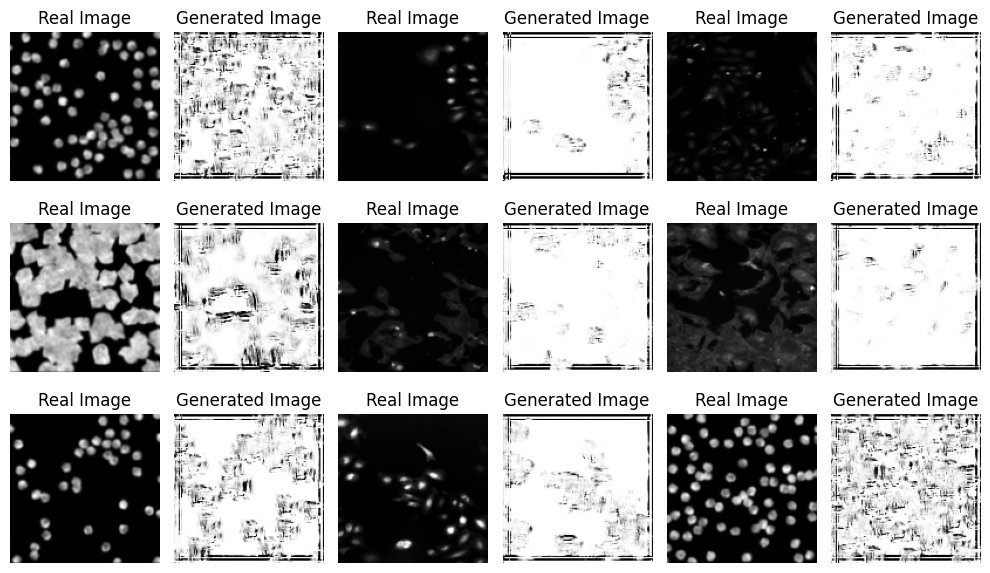

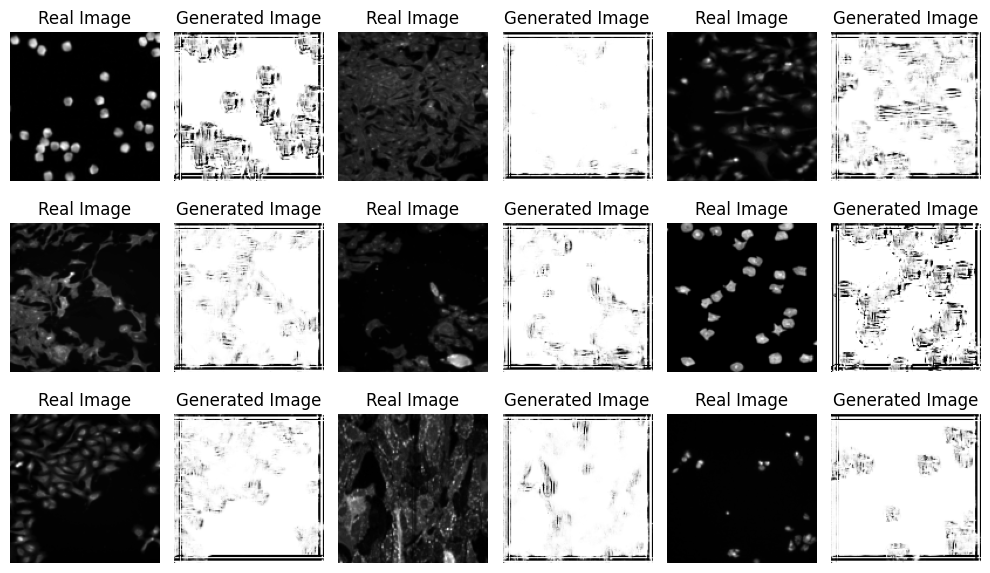

In [5]:

fig, axes = plt.subplots(3, 6, figsize=(10, 6))  
for i in range(9):
    ax = axes[i//3, 2*(i%3)]
    ax.imshow(R_Images_0[i].cpu().squeeze(), cmap='gray') #R_Images und Generated_Images-Name Änderung kan für Unterschiedliche Epoch Image Dastellung 
    ax.axis('off')
    ax.set_title('Real Image')

    ax = axes[i//3, 2*(i%3) + 1]
    ax.imshow(Generated_Images_0[i].cpu().squeeze().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title('Generated Image')

plt.tight_layout()
plt.show()   

fig, axes = plt.subplots(3, 6, figsize=(10, 6))  
for i in range(9):
    ax = axes[i//3, 2*(i%3)]
    ax.imshow(R_Images_1[i].cpu().squeeze(), cmap='gray')  
    ax.axis('off')
    ax.set_title('Real Image')

    ax = axes[i//3, 2*(i%3) + 1]
    ax.imshow(Generated_Images_1[i].cpu().squeeze().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title('Generated Image')

plt.tight_layout()
plt.show()   


fig, axes = plt.subplots(3, 6, figsize=(10, 6))  
for i in range(9):
    ax = axes[i//3, 2*(i%3)]
    ax.imshow(R_Images_2[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title('Real Image')

    ax = axes[i//3, 2*(i%3) + 1]
    ax.imshow(Generated_Images_2[i].cpu().squeeze().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title('Generated Image')

plt.tight_layout()
plt.show()  

fig, axes = plt.subplots(3, 6, figsize=(10, 6))  
for i in range(9):
    ax = axes[i//3, 2*(i%3)]
    ax.imshow(R_Images_3[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title('Real Image')

    ax = axes[i//3, 2*(i%3) + 1]
    ax.imshow(Generated_Images_3[i].cpu().squeeze().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title('Generated Image')

plt.tight_layout()
plt.show()  

fig, axes = plt.subplots(3, 6, figsize=(10, 6))  
for i in range(9):
    ax = axes[i//3, 2*(i%3)]
    ax.imshow(R_Images_4[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title('Real Image')

    ax = axes[i//3, 2*(i%3) + 1]
    ax.imshow(Generated_Images_4[i].cpu().squeeze().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title('Generated Image')

plt.tight_layout()
plt.show()  



fig, axes = plt.subplots(3, 6, figsize=(10, 6))  
for i in range(9):
    ax = axes[i//3, 2*(i%3)]
    ax.imshow(R_Images_5[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title('Real Image')

    ax = axes[i//3, 2*(i%3) + 1]
    ax.imshow(Generated_Images_5[i].cpu().squeeze().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title('Generated Image')

plt.tight_layout()
plt.show()  









fig, axes = plt.subplots(3, 6, figsize=(10, 6))  
for i in range(9):
    ax = axes[i//3, 2*(i%3)]
    ax.imshow(R_Images_6[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title('Real Image')

    ax = axes[i//3, 2*(i%3) + 1]
    ax.imshow(Generated_Images_6[i].cpu().squeeze().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title('Generated Image')

plt.tight_layout()
plt.show() 





fig, axes = plt.subplots(3, 6, figsize=(10, 6))  
for i in range(9):
    ax = axes[i//3, 2*(i%3)]
    ax.imshow(R_Images_7[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title('Real Image')

    ax = axes[i//3, 2*(i%3) + 1]
    ax.imshow(Generated_Images_7[i].cpu().squeeze().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title('Generated Image')

plt.tight_layout()
plt.show() 




fig, axes = plt.subplots(3, 6, figsize=(10, 6))  
for i in range(9):
    ax = axes[i//3, 2*(i%3)]
    ax.imshow(R_Images_8[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title('Real Image')

    ax = axes[i//3, 2*(i%3) + 1]
    ax.imshow(Generated_Images_8[i].cpu().squeeze().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title('Generated Image')

plt.tight_layout()
plt.show() 



fig, axes = plt.subplots(3, 6, figsize=(10, 6))  
for i in range(9):
    ax = axes[i//3, 2*(i%3)]
    ax.imshow(R_Images_9[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title('Real Image')

    ax = axes[i//3, 2*(i%3) + 1]
    ax.imshow(Generated_Images_9[i].cpu().squeeze().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title('Generated Image')

plt.tight_layout()
plt.show() 





fig, axes = plt.subplots(3, 6, figsize=(10, 6))  
for i in range(9):
    ax = axes[i//3, 2*(i%3)]
    ax.imshow(R_Images_10[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title('Real Image')

    ax = axes[i//3, 2*(i%3) + 1]
    ax.imshow(Generated_Images_10[i].cpu().squeeze().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title('Generated Image')

plt.tight_layout()
plt.show() 